In [34]:
# define the system
from IPython.display import display
import ipywidgets as ipw
import numpy as np
import bqplot as bqp

def y(x):
    return(np.exp(-0.1*x) * np.sin(x))

def Y(s1, s2):
    s = s1 +  1j * s2
    Y = 1 / s
    return(Y.real, Y.imag)

tArray = np.linspace(0, 10, 100)
s1Array = np.linspace(-10, 10, 100) # make sure both of them don't pass through 0 to avoid infinity
s2Array = np.linspace(-10, 10, 100)

yArray = y(tArray)
Y1Array, Y2Array = Y(s1Array, s2Array)

isContinousUpdateOn = True # when turned on it's sluggish without throttling

In [39]:
# throttling as per https://ipywidgets.readthedocs.io/en/latest/examples/Widget%20Events.html
import asyncio
from time import time

class Timer:
    def __init__(self, timeout, callback):
        self._timeout = timeout
        self._callback = callback
        self._task = asyncio.ensure_future(self._job())

    async def _job(self):
        await asyncio.sleep(self._timeout)
        self._callback()

    def cancel(self):
        self._task.cancel()
        
def throttle(wait):
    """ Decorator that prevents a function from being called
        more than once every wait period. """
    def decorator(fn):
        time_of_last_call = 0
        scheduled = False
        new_args, new_kwargs = None, None
        def throttled(*args, **kwargs):
            nonlocal new_args, new_kwargs, time_of_last_call, scheduled
            def call_it():
                nonlocal new_args, new_kwargs, time_of_last_call, scheduled
                time_of_last_call = time()
                fn(*new_args, **new_kwargs)
                scheduled = False
            time_since_last_call = time() - time_of_last_call
            new_args = args
            new_kwargs = kwargs
            if not scheduled:
                new_wait = max(0, wait - time_since_last_call)
                Timer(new_wait, call_it)
                scheduled = True
        return throttled
    return decorator

In [9]:
# sliders styling and whatnot, normally should be hidden from view
tSlider = ipw.FloatSlider(
    value=tArray[0],
    min=np.min(tArray), 
    max=np.max(tArray),
    description='$t$:',
    disabled=False, 
    step=tArray[1] - tArray[0],
    readout=True,
    readout_format='.1f',
    continuous_update=isContinousUpdateOn,
    layout=ipw.Layout(width='100%', height='80px'), 
)
ySlider = ipw.FloatSlider(
    value=yArray[0],
    min=np.min(yArray), 
    max=np.max(yArray),
    description='$y$:',
    disabled=True,
    readout=True,
    readout_format='.4f',
    continuous_update=isContinousUpdateOn,
    layout=ipw.Layout(width='100%', height='80px'), 
)
s1Slider = ipw.FloatSlider(
    value=s1Array[0],
    min=np.min(s1Array), 
    max=np.max(s1Array), 
    description='Real[$s$]:',
    disabled=False,
    step=s1Array[1] - s1Array[0],
    readout=True,
    readout_format='.1f',
    continuous_update=isContinousUpdateOn,
    layout=ipw.Layout(width='50%', height='80px'),  
)
s2Slider = ipw.FloatSlider(
    value=s2Array[0],
    min=np.min(s2Array), 
    max=np.max(s2Array), 
    description='Imag[$s$]:',
    disabled=False,
    step=s2Array[1] - s2Array[0],
    readout=True,
    readout_format='.1f',
    continuous_update=isContinousUpdateOn,
    layout=ipw.Layout(width='50%', height='80px'), 
)
Y1Slider = ipw.FloatSlider(
    value=Y1Array[0],
    min=np.min(Y1Array), 
    max=np.max(Y1Array), 
    description='Real[$Y(s)$]:',
    disabled=True,
    readout=True,
    readout_format='.4f',
    continuous_update=isContinousUpdateOn,
    layout=ipw.Layout(width='50%', height='80px'), 
)
Y2Slider = ipw.FloatSlider(
    value=Y2Array[0],
    min=np.min(Y2Array), 
    max=np.max(Y2Array), 
    description='Imag[$Y(s)$]:',
    disabled=True,
    readout=True,
    readout_format='.4f',
    continuous_update=isContinousUpdateOn,
    layout=ipw.Layout(width='50%', height='80px'), 
)
fourierCheckbox = ipw.Checkbox(
    value=False,
    description='Fourier Mode',
    disabled=False,
    indent=False
)

# bqplot slider & plot interaction 

In [74]:
animDuration = 100

# t->y
tSlider.value = tArray[0]
ySlider.value = yArray[0]
xSc = bqp.LinearScale()
ySc = bqp.LinearScale()
xAxis = bqp.Axis(label='t', scale=xSc, tick_format='0.0f', grid_lines='none')
yAxis = bqp.Axis(label='y(t)', scale=ySc, orientation='vertical', tick_format='0.2f', grid_lines='none')
line = bqp.Lines(x=tArray, y=yArray, scales={'x': xSc, 'y': ySc}, labels=['y'], display_legend=True)
point = bqp.Scatter(x=[tArray[0]], y=[yArray[0]], scales={'x': xSc, 'y': ySc}, default_size=128)
#label = bqp.Label(x=[tArray[0]], y=[yArray[0]], scales={'x': xSc, 'y': ySc}, x_offset = 5, y_offset = 5, text=['{:.4f}'.format(yArray[0])])
tyFig = bqp.Figure(axes=[xAxis, yAxis],  marks=[line, point], title='y(t) = {:.4f}'.format(yArray[0]), animation_duration=animDuration)

@throttle(0.5)
def handle_tSlider(change):
    tValue = change['new']
    yValue = y(tValue)
    ySlider.value = yValue
    point.x = [tValue]
    point.y = [yValue]
    #label.x = [tValue]
    #label.y = [yValue]
    #label.text = ['{:.4f}'.format(yValue)]
    tyFig.title = 'y(t) = {:.4f}'.format(yValue)
tSlider.observe(handle_tSlider, names='value')

# s->Y
s1Slider.value = s1Array[0] 
s2Slider.value = s2Array[0]
Y1Slider.value = Y1Array[0]
Y2Slider.value = Y2Array[0]
fourierCheckbox.value = False

s1Sc = bqp.LinearScale()
s1Sc.min = np.min(s1Array)
s1Sc.max = np.max(s1Array)
s2Sc = bqp.LinearScale()
s2Sc.min = np.min(s2Array)
s2Sc.max = np.max(s2Array)
Y1Sc = bqp.LinearScale()
Y1Sc.min = -1 #np.min(Y1Array)
Y1Sc.max = 1 #np.max(Y1Array)
Y2Sc = bqp.LinearScale()
Y2Sc.min = -1 #np.min(Y2Array)
Y2Sc.max = 1 #np.max(Y2Array)
s1Axis = bqp.Axis(label='Real', scale=s1Sc, tick_format='0.0f', grid_lines='none')
s2Axis = bqp.Axis(label='Imaginary', scale=s2Sc, orientation='vertical', tick_format='0.0f', grid_lines='none')
Y1Axis = bqp.Axis(label='Real', scale=Y1Sc, tick_format='0.0f', grid_lines='none')
Y2Axis = bqp.Axis(label='Imaginary', scale=Y2Sc, orientation='vertical', tick_format='0.0f', grid_lines='none')
sRealLine = bqp.Lines(x=[np.min(s1Array), np.max(s1Array)], y=[0,0], scales={'x': s1Sc, 'y': s2Sc}, colors=['black'], stroke_width=0.5)
sImagLine = bqp.Lines(x=[0,0], y=[np.min(s2Array), np.max(s2Array)], scales={'x': s1Sc, 'y': s2Sc}, colors=['black'], stroke_width=0.5)
YRealLine = bqp.Lines(x=[np.min(Y1Array), np.max(Y1Array)], y=[0,0], scales={'x': Y1Sc, 'y': Y2Sc}, colors=['black'], stroke_width=0.5)
YImagLine = bqp.Lines(x=[0,0], y=[np.min(Y2Array), np.max(Y2Array)], scales={'x': Y1Sc, 'y': Y2Sc}, colors=['black'], stroke_width=0.5)
inputPoint = bqp.Scatter(x=[s1Array[0]], y=[s2Array[0]], scales={'x': s1Sc, 'y': s2Sc}, enable_move=True, restrict_y=False)
outputPoint = bqp.Scatter(x=[Y1Array[0]], y=[Y2Array[0]], scales={'x': Y1Sc, 'y': Y2Sc})
sFig = bqp.Figure(axes=[s1Axis, s2Axis], marks=[sRealLine, sImagLine, inputPoint], layout=ipw.Layout(width='50%', height='500px'), title='s = {:.2f}, {:.2f}j'.format(s1Array[0], s2Array[0]), animation_duration=animDuration)
YFig = bqp.Figure(axes=[Y1Axis, Y2Axis], marks=[YRealLine, YImagLine, outputPoint], layout=ipw.Layout(width='50%', height='500px'), title='Y(s) = {:.2f}, {:.2f}j'.format(Y1Array[0], Y2Array[0]), animation_duration=animDuration)

def update_YSliders(s1Value, s2Value):
    Y1Value, Y2Value = Y(s1Value, s2Value)
    Y1Slider.value = Y1Value
    Y2Slider.value = Y2Value
    outputPoint.x = [Y1Value]
    outputPoint.y = [Y2Value]
    YFig.title = 'Y(s) = {:.2f}, {:.2f}j'.format(Y1Value, Y2Value)
    
@throttle(0.5)    
def handle_s1Slider(change):
    s1Value = change['new']
    s2Value = s2Slider.value
    update_YSliders(s1Value, s2Value)
    inputPoint.x = [s1Value]
    sFig.title = 's = {:.2f}, {:.2f}j'.format(s1Value, s2Value)

@throttle(0.5)    
def handle_s2Slider(change):
    s1Value = s1Slider.value
    s2Value = change['new'] 
    update_YSliders(s1Value, s2Value)
    inputPoint.y = [s2Value]
    sFig.title = 's = {:.2f}, {:.2f}j'.format(s1Value, s2Value)

@throttle(0.5)
def handle_dragging(name, value):
    s1Slider.value = value['point']['x']
    s2Slider.value = value['point']['y']

def handle_fourierCheckbox(change):
    if change['new'] == True:
        s1Slider.value = 0
        s1Slider.disabled = True
        inputPoint.restrict_y = True
    else:
        s1Slider.disabled = False
        outputPoint.restrict_y = False
        
fourierCheckbox.observe(handle_fourierCheckbox, names='value')    
s1Slider.observe(handle_s1Slider, names='value')    
s2Slider.observe(handle_s2Slider, names='value')   
inputPoint.on_drag_end(handle_dragging)   

In [75]:
display(ipw.VBox([ipw.HBox([tSlider, ySlider]), tyFig]))
display(ipw.VBox([ipw.HBox([s1Slider, Y1Slider]), ipw.HBox([s2Slider, Y2Slider]), fourierCheckbox]))
display(ipw.HBox([sFig, YFig]))    

## COMPARISON: matplotlib slider & plot interaction 

In [29]:
from matplotlib import pyplot as plt
#%matplotlib inline # DOES NOT WORK/UPDATE
%matplotlib widget
fig = plt.figure()
ax = fig.gca()
hPlot = ax.plot(tArray, yArray, linewidth=2, label='$y$');
hScatter = ax.scatter(tArray[0], yArray[0], 50)
hText = ax.text(tArray[0], yArray[0], ' ${:.3f}$'.format(yArray[0]))
ax.set_xlabel('$t$');
ax.set_ylabel('$y(t)$');
plt.legend(loc="best");

def handle_tSlider_change(change): 
    tValue = change['new']
    yValue = y(tValue)
    ySlider.value = yValue
    hScatter.set_offsets((tValue, yValue))
    hText.set_position((tValue, yValue))
    hText.set_text(' ${:.3f}$'.format(yValue))
tSlider.observe(handle_tSlider_change, names='value')

display(ipw.HBox([tSlider, ySlider]))

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

# linking widgets

In [13]:
a = ipw.FloatText()
b = ipw.FloatSlider()
display(a,b)

mylink = ipw.jslink((a, 'value'), (b, 'value'))

FloatText(value=0.0)

FloatSlider(value=0.0)

# sympy laplace transform test

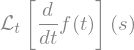

In [15]:
import sympy as sy
from sympy.abc import t, s, a
sy.init_printing()
f = sy.Function('f')
sy.laplace_transform(f(t).diff(), t, s)

# draggable points in matplotlib example 
https://stackoverflow.com/questions/50439506/dragging-points-in-matplotlib-interactive-plot

# other notes

In [35]:
import matplotlib.pyplot as plt
%matplotlib widget
def fun(x, y):
    x, y = Y(x, y)
    return np.sqrt(x**2 + y**2)
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
x, y = np.meshgrid(s1Array, s2Array)
zs = np.array(fun(np.ravel(x), np.ravel(y)))
z = zs.reshape(x.shape)
ax.plot_surface(x, y, z)
ax.set_zlim(0, 5)
plt.show()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [34]:
import ipywidgets as widgets

out = widgets.Output()
def on_value_change(change):
    with out:
        print(change['new'])

slider = widgets.IntSlider(min=1, max=100, step=1, continuous_update=True)
play = widgets.Play(min=1, interval=2000)

slider.observe(on_value_change, 'value')
widgets.jslink((play, 'value'), (slider, 'value'))
widgets.VBox([play, slider, out])